In [36]:
import tensorflow as tf
import tensorflow_text as tf_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def load_data(path):
	with open('fra.txt','r') as f:
		lines = f.read().split('\n')[:-1]

	pairs = [line.split('\t') for line in lines]

	context = np.array([context for context,target    in pairs])
	target = np.array([target for context,target in pairs])

	return target, context

In [38]:
target_raw, context_raw = load_data('fra.txt')

In [39]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
	tf.data.Dataset
	.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
	.shuffle(BUFFER_SIZE)
	.batch(BATCH_SIZE))
val_raw = (
	tf.data.Dataset
	.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
	.shuffle(BUFFER_SIZE)
	.batch(BATCH_SIZE))

In [40]:
for example_context_strings, example_target_strings in train_raw.take(1):
	print(example_context_strings[:5])
	print()
	print(example_target_strings[:5])
	print(example_context_strings.shape)
	break

tf.Tensor(
[b"That's what I'm thinking." b'Have you heard from the rest of the team?'
 b'Who was the woman you were talking to?' b'I must open the window.'
 b'I can fix it.'], shape=(5,), dtype=string)

tf.Tensor(
[b"C'est ce \xc3\xa0 quoi je suis en train de penser."
 b"As-tu entendu des nouvelles du reste de l'\xc3\xa9quipe ?"
 b'Qui \xc3\xa9tait celle \xc3\xa0 qui vous parliez ?'
 b'Il me faut ouvrir la fen\xc3\xaatre.' b'Je peux le r\xc3\xa9parer.'], shape=(5,), dtype=string)
(64,)


In [41]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [42]:
def tf_lower_and_split_punct(text):
	# Split accented characters.
	text = tf_text.normalize_utf8(text, 'NFKD')
	text = tf.strings.lower(text)
	# Keep space, a to z, and select punctuation.
	text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
	# Add spaces around punctuation.
	text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
	# Strip whitespace.
	text = tf.strings.strip(text)

	text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
	return text

In [43]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [44]:
max_vocab_size = 10000

context_text_processor = tf.keras.layers.TextVectorization(
	standardize=tf_lower_and_split_punct,
	max_tokens=max_vocab_size,
	ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [45]:
target_text_processor = tf.keras.layers.TextVectorization(
	standardize=tf_lower_and_split_punct,
	max_tokens=max_vocab_size,
	ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']

In [46]:
example_tokens = context_text_processor(example_context_strings)
print(example_tokens[0])
print(example_context_strings[0])
print(example_tokens[2])
print(example_context_strings[2])

tf.Tensor([  2  92  30  29 497   4   3], shape=(7,), dtype=int64)
tf.Tensor(b"That's what I'm thinking.", shape=(), dtype=string)
tf.Tensor([  2  91  24   8 576   6  44 295   7   9   3], shape=(11,), dtype=int64)
tf.Tensor(b'Who was the woman you were talking to?', shape=(), dtype=string)


In [47]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] thats what im thinking . [END]'

In [48]:
context_vocab.shape

(10000,)

Text(0.5, 1.0, 'Mask')

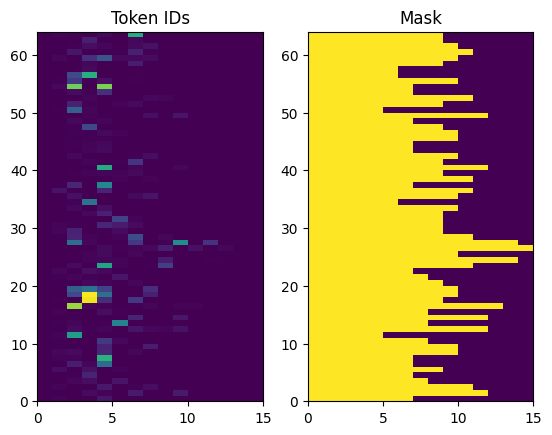

In [49]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [50]:
def process_text(context, target):
	context = context_text_processor(context).to_tensor()
	target = target_text_processor(target)
	targ_in = target[:,:-1].to_tensor()
	targ_out = target[:,1:].to_tensor()
	return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [51]:
for (ex_context_tok,ex_tar_in),ex_tar_out in train_ds.take(1):
	print(ex_context_tok[0,:].numpy())
	print(ex_context_tok.numpy().shape)
	print()
	print(ex_tar_in[0,:].numpy())
	print(ex_tar_in.numpy().shape)
	print(ex_tar_out[0,:].numpy())
	print(ex_tar_out.numpy().shape)

[   2   32   43   21  537 5353    4    3    0    0    0    0    0    0
    0    0    0]
(64, 17)

[   2   85  104 1599 3837    4    0    0    0    0    0    0    0    0
    0    0    0]
(64, 17)
[  85  104 1599 3837    4    3    0    0    0    0    0    0    0    0
    0    0    0]
(64, 17)


In [52]:
units = 256

In [53]:
class Encoder(tf.keras.layers.Layer):
	def __init__(self, text_processor, units,**kwargs):
		super(Encoder,self).__init__()
		self.text_processor = text_processor
		self.vocab_size = text_processor.vocabulary_size()
		self.units = units

		self.embedding = tf.keras.layers.Embedding(self.vocab_size,units,mask_zero=True)

		self.rnn = tf.keras.layers.Bidirectional(
			merge_mode='sum',
			layer=tf.keras.layers.GRU(units,
									  return_sequences=True,
									  recurrent_initializer='glorot_uniform')
		)
	
	def call(self, x):
		x = self.embedding(x)
		x = self.rnn(x)
		return x

	def convert_input(self,texts):
		texts = tf.convert_to_tensor(texts)
		if(len(texts))==0:
			texts = tf.convert_to_tensor(texts)[tf.newaxis]
		context = self.text_processor(texts).to_tensor()
		context = self(context)
		return context

In [54]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, units)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 256)


In [55]:
class CrossAttention(tf.keras.layers.Layer):
	def __init__(self, units,**kwargs):
		super().__init__()
		self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units,num_heads=1,**kwargs)
		self.layernorm = tf.keras.layers.LayerNormalization()
		self.add = tf.keras.layers.Add()

	def call(self,x,context):
		attn_output,attn_scores = self.mha(
			query = x,
			value = context,
			return_attention_scores = True
		)
		attn_scores = tf.reduce_mean(attn_scores,axis=1) 
		self.last_attention_weights = attn_scores

		x = self.add([x,attn_output])
		x = self.layernorm(x)
		return x

In [56]:
attention_layer = CrossAttention(units)
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),output_dim=units,mask_zero=True)
ex_tar_emb = embed(ex_tar_in)

result = attention_layer(ex_tar_emb,ex_context)

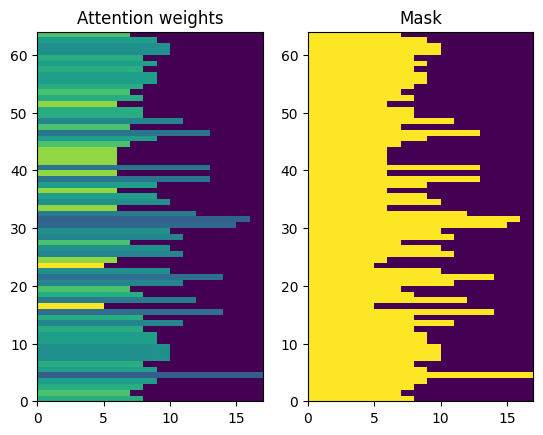

In [57]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [58]:
class Decoder(tf.keras.layers.Layer):  
		def __init__(self, text_processor,units):
				super().__init__()
				self.text_processor = text_processor
				self.units = units

				self.vocab_size = text_processor.vocabulary_size()

				self.word_to_id = tf.keras.layers.StringLookup(
				vocabulary=text_processor.get_vocabulary(),
				mask_token='', oov_token='[UNK]')
				self.id_to_word = tf.keras.layers.StringLookup(
						vocabulary=text_processor.get_vocabulary(),
						mask_token='', oov_token='[UNK]',
						invert=True)
				self.start_token = self.word_to_id('[START]')
				self.end_token = self.word_to_id('[END]')

				self.embedding = tf.keras.layers.Embedding(self.vocab_size,
																							 units, mask_zero=True)

				# 2. The RNN keeps track of what's been generated so far.
				self.rnn = tf.keras.layers.GRU(units,
																		return_sequences=True,
																		return_state=True,
																		recurrent_initializer='glorot_uniform')

				# 3. The RNN output will be the query for the attention layer.
				self.attention = CrossAttention(units)

				# 4. This fully connected layer produces the logits for each
				# output token.
				self.output_layer = tf.keras.layers.Dense(self.vocab_size)

				
		def call(self,context,x,state=None,return_state = False):
				x = self.embedding(x)
				x,state = self.rnn(x,initial_state = state)
				x = self.attention(x,context)
				self.last_attention_weights = self.attention.last_attention_weights
				logits = self.output_layer(x)
				
				if return_state:
						return logits,state
				
				else:   
						return logits
				
		def get_initial_state(self, context):
			batch_size = tf.shape(context)[0]
			start_tokens = tf.fill([batch_size, 1], self.start_token)
			done = tf.zeros([batch_size, 1], dtype=tf.bool)
			embedded = self.embedding(start_tokens)
			return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

		def tokens_to_text(self, tokens):
			words = self.id_to_word(tokens)
			result = tf.strings.reduce_join(words, axis=-1, separator=' ')
			result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
			result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
			return result

		def get_next_token(self, context, next_token, done, state, temperature = 0.0):
			logits, state = self(
				context, next_token,
				state = state,
				return_state=True) 

			if temperature == 0.0:
				next_token = tf.argmax(logits, axis=-1)
			else:
				logits = logits[:, -1, :]/temperature
				next_token = tf.random.categorical(logits, num_samples=1)

			# If a sequence produces an `end_token`, set it `done`
			done = done | (next_token == self.end_token)
			# Once a sequence is done it only produces 0-padding.
			next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

			return next_token, done, state
				

In [59]:
decoder  = Decoder(target_text_processor,units)

logits = decoder(ex_context, ex_tar_in)

In [60]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
	# Run one step.
	next_token, done, state = decoder.get_next_token(
			ex_context, next_token, done, state, temperature=1.0)
	# Add the token to the output.
	tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:5].numpy()

array([b'privilege evidence limprimante principalement pese enervees base survecu ennuye acide',
       b'cave repasse contrat prevenues plie charrue arrives fous alice raconta',
       b'supplier lecon os empreinte prevoir berceau inspire interets paresse derange',
       b'volontaires perdues destomac reparle liquide tiendra etageres medicaux reprochez allies',
       b'marient souffrant concurrence rechercher epicerie faistu fait laissezmoi donde traitee'],
      dtype=object)

In [61]:
class Translator(tf.keras.Model):
		def __init__(self,units, context_text_processor,target_text_processor):
				super().__init__()

				encoder = Encoder(context_text_processor,units)
				decoder = Decoder(target_text_processor,units)

				self.encoder = encoder
				self.decoder = decoder


		def call(self,inputs):
			context,x = inputs\

			context = self.encoder(context)

			logits = self.decoder(context,x)
			
			try:
					del logits._keras_mask
			except AttributeError:
					pass
			
			return logits
				
		def translate(self,
									texts, *,
									max_length=50,
									temperature=0.0):
			# Process the input texts
			context = self.encoder.convert_input(texts)
			batch_size = tf.shape(texts)[0]

			# Setup the loop inputs
			tokens = []
			attention_weights = []
			next_token, done, state = self.decoder.get_initial_state(context)

			for _ in range(max_length):
				# Generate the next token
				next_token, done, state = self.decoder.get_next_token(
						context, next_token, done,  state, temperature)

				# Collect the generated tokens
				tokens.append(next_token)
				attention_weights.append(self.decoder.last_attention_weights)

				if tf.executing_eagerly() and tf.reduce_all(done):
					break

			# Stack the lists of tokens and attention weights.
			tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
			self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

			result = self.decoder.tokens_to_text(tokens)
			return result

In [62]:
model =  Translator(units,context_text_processor,target_text_processor)
logits = model((ex_context_tok,ex_tar_in))

In [63]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [64]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [65]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 4s 25ms/step - loss: 9.2194 - masked_acc: 0.0000e+00 - masked_loss: 9.2194


{'loss': 9.219377517700195,
 'masked_acc': 0.0,
 'masked_loss': 9.219377517700195}

In [66]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 11s 47ms/step - loss: 5.5217 - masked_acc: 0.2164 - masked_loss: 5.5217 - val_loss: 4.5326 - val_masked_acc: 0.3209 - val_masked_loss: 4.5326
Epoch 2/100
100/100 [==============================] - 4s 44ms/step - loss: 4.1060 - masked_acc: 0.3685 - masked_loss: 4.1060 - val_loss: 3.7122 - val_masked_acc: 0.4063 - val_masked_loss: 3.7122
Epoch 3/100
100/100 [==============================] - 4s 44ms/step - loss: 3.4520 - masked_acc: 0.4351 - masked_loss: 3.4520 - val_loss: 3.1444 - val_masked_acc: 0.4770 - val_masked_loss: 3.1444
Epoch 4/100
100/100 [==============================] - 4s 44ms/step - loss: 3.0022 - masked_acc: 0.4902 - masked_loss: 3.0022 - val_loss: 2.7720 - val_masked_acc: 0.5155 - val_masked_loss: 2.7720
Epoch 5/100
100/100 [==============================] - 4s 45ms/step - loss: 2.6886 - masked_acc: 0.5337 - masked_loss: 2.6886 - val_loss: 2.4851 - val_masked_acc: 0.5599 - val_masked_loss: 2.4851
Epoch 6/100
100/100

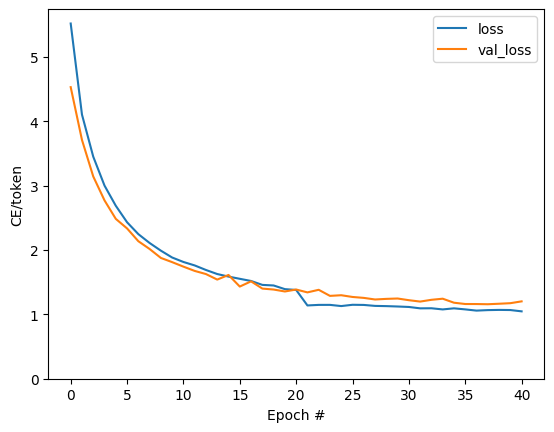

In [67]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

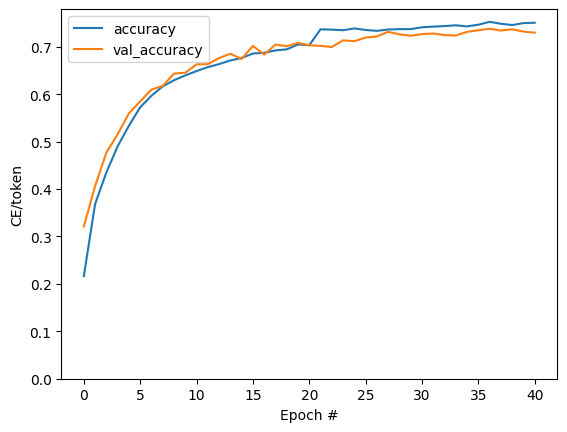

In [68]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [69]:
result = model.translate(['Ce vélo est trop petit pour vous']) # Are you still home

In [70]:
result[0].numpy().decode()

'[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'